In [2]:
from Basics import *
setplot(dark=True)

# Mass conversion

In [ ]:
pyccl.halos.concentration.diemer15

In [ ]:
import pyccl

In [ ]:
pyccl.halos.concentration.ConcentrationDiemer15.

In [ ]:
cosmo = pyccl.Cosmology(h=0.7, Omega_c=0.25, Omega_b=0.044, n_s=0.95, sigma8=0.8,transfer_function='bbks')

massconv = pyccl.halos.massdef.mass_translator(mass_in='200c', mass_out='vir',
                                    concentration='Diemer15')

In [ ]:
np.log10(massconv(cosmo, 1e12, 1/(1+0.54)))

# Dust

In [ ]:
schaan = Measurements.Schaan2021()

fact = (schaan.T_CMB*1e6)*(Measurements.fnu(schaan.freq, schaan.T_CMB))*4.54591666
plt.errorbar(schaan.thetas, schaan.tSZdata*fact, -schaan.tSZerr*fact)
plt.plot(schaan.thetas, schaan.dustprof*fact)

np.genfromtxt("/global/homes/c/cpopik/fig6_TNG_H_dust.txt").T

In [82]:
def aperture_photometry(thts, prof2D_beam, NNR, disc_fac):
    sig_all_p_beam = [] 
    for tht in thts:
        dtht_use = np.arctan(np.arctan(np.radians(tht / 60.0))) / NNR
        thta_use = (np.arange(NNR) + 1.0) * dtht_use
        sig_p = 2.0 * np.pi * dtht_use * np.sum(thta_use * prof2D_beam(thta_use))

        dtht2_use = np.arctan(np.arctan(np.radians(tht * disc_fac / 60.0))) / NNR
        thta2_use = (np.arange(NNR) + 1.0) * dtht2_use
        sig2_p = 2.0 * np.pi * dtht2_use * np.sum(thta2_use * prof2D_beam(thta2_use))

        sig_all_p_beam.append(sig_p-(sig2_p-sig_p))

    return np.array(sig_all_p_beam)

In [290]:
A_dust = 0.2*(u.kJy/u.sr)
T_dust = 20*u.K
beta_dust = 1.1
c0 = 5
c1 = -1.5
c2 = 0.1

def x(nu, T):
    return (nu*c.h/c.k_B/T).decompose()

def dB_dT(nu, T):
    return (2 * c.k_B*nu**2/c.c**2 * x(nu, T)**2 * np.exp(x(nu, T)) /
             ((np.exp(x(nu, T)) - 1)**2))/u.sr

def dust(nu, R, T, nu0):
    return A_dust*(nu*(1+z)/nu0)**(beta_dust+3) * (np.exp(x(nu0, T))-1)/(np.exp(x(nu*(1+z), T))-1) * (c0+c1*R+c2*R**2)

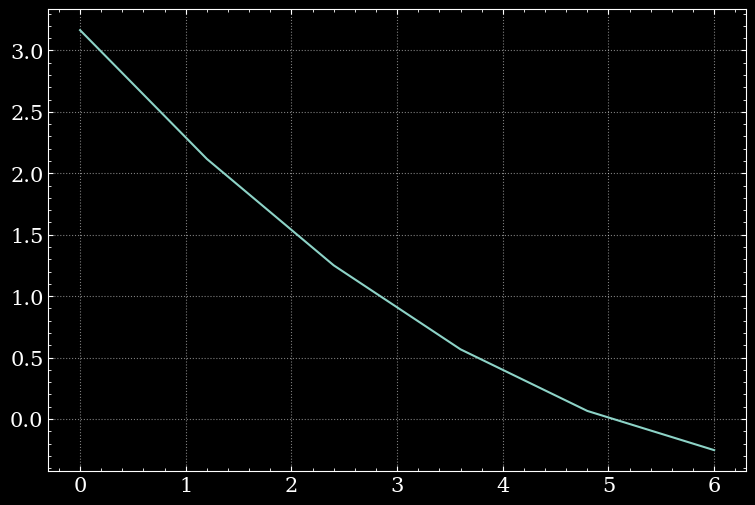

In [300]:
thetas = np.linspace(0, 6, 6)
T_CMB = 2.7*u.K
nu0 = (c.c/(90*u.um)).to(u.GHz)
nu = (c.c/(250*u.um)).to(u.GHz)
z = 0.55

plt.plot(thetas, dust(nu, thetas, T_dust, nu0))

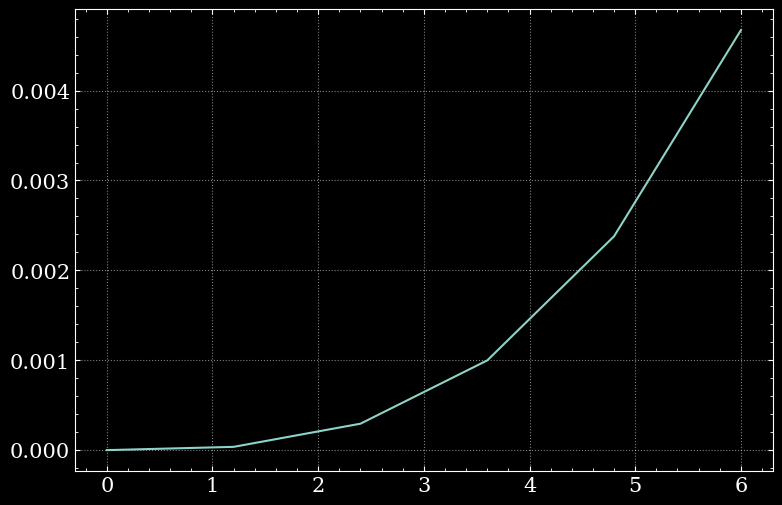

In [313]:
dustprof = lambda theta: (dust(nu, theta, T_dust, nu0)/dB_dT(nu, T_dust)).to(u.uK).value
plt.plot(thetas, aperture_photometry(thetas, dustprof, 100, np.sqrt(2))*(u.sr.to(u.arcmin**2)))

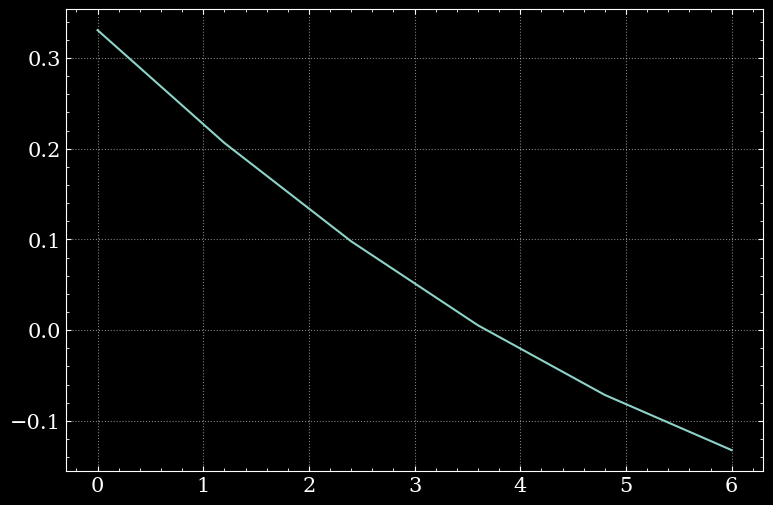

In [25]:
thetas = np.linspace(0, 6, 6)
plt.plot(thetas, dust(150*u.GHz, thetas))

In [ ]:
plt.plot(model.thetas, dust(150*u.GHz, model.thetas))

In [ ]:
(dust(150*u.GHz, model.thetas)*c.sigma_T/c.c**2/c.m_e*4*np.pi*u.sr).decompose()